In [1]:
import torch
import torch.nn as nn
from finetune.cifar10_models import resnet18

## Binary Image Classification with a Pre-Trained Model

In the previous notebook, you were introduced to pre-trained models from a feature-based approach. You saw how we could use techniques like OLS to produce predictions using a naive feature mapping. Then, you implemented custom convolutional filters to produce more substantive and efficient feature representations for the images. Then you saw how a pre-trained model, specifically ResNet18, produced much better featurizations and achieved the highest train/val accuracy for that classification problem. 

In this part of the notebook, you will walk through a practical exercise of loading a pre-trained model, freezing its hidden layers, and fine-tuning its last fully connected layer for a specific task. This is analagous to doing logistic regression on the pre-trained models featurizations. However, this section will walk you through setting up a basic PyTorch workflow, which consists of model setup, data preparation, training, and evaluation. This is a highly common paradigm in practice, and it is important for you to get experience with this.

The setting we will work with first is the problem of classifying between 2 classes of images in CIFAR-10, the dataset you saw in the last notebook. Then we will look at a specific case of where pre-trained models really shine -- when there is a lack of available training data.

### Loading a pre-trained model

Let us first load a pre-trained ResNet18 model file, if you are interested in how this works, feel free to 
check out its implementation in ```finetune/cifar10_models```. Also, a minor detail you can feel free to gloss over for now: we need to set the model to evaluation mode (```.eval()```) since we want to prevent any of ResNet's BatchNorm or Dropout layers from being activated when producing the features for fine-tuning.

In [39]:
model_ft = resnet18(pretrained=True).eval()

First, let us take a look at this pre-trained model. What do you notice about its last layer? What kind of layer is it? What are its input and output sizes?

In [40]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Observation:
Insert observation here

Now, we need to fine-tune this model for our task. This means "freezing" many of the layers that already have
pre-trained weights loaded into them. In order to freeze these layers, we need to tell PyTorch that the parameters of these layers are not meant to get their gradients updated during the training step. Take a look at the PyTorch [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=parameters#torch.nn.Module.parameters) and freeze all of the parameters for ```model_ft```. Hint: what are some attributes of ```nn.Module.parameters```?

In [41]:
for param in model_ft.parameters():
    param.requires_grad = False

We have just frozen all of the model's layers, but we still need to fine-tune the last layer. Since we are working with binary classification, we need to reshape the output of the last fully connected layer. We can do this by creating a new output layer. This does two things -- 1) by default, when creating a new layer, it is "unfrozen", meaning its gradients will be updated during training and 2) this allows us to create a layer that is specific to our task. 

Re-assign the model's last fully connected layer to a new linear layer that will be able to handle binary classification.

In [42]:
feature_dim = model_ft.fc.in_features
model_ft.fc = nn.Linear(feature_dim, 2)

### Preparing Data

Now, we need to need to source the data for our binary classification task. You worked with CIFAR-10 in the previous notebook. Here we will work with the same dataset, but instead use PyTorch's Data Framework. Let's first import the necessary tools for this. 

In [43]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

An important aspect of working with data for ML learning models, is normalization. You've seen in previous assignments the effect of normalization on models. Here, we need to make sure that we normalize our data in the same way that the pre-trained ResNet18 was trained. The following code uses PyTorch's transforms framework to convert image data into Tensors (this rescales images into the range [0,1]) and then normalizes them channel-wise, such that they comply with how ResNet18 was originally trained.

In [44]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])

One of the neat features of PyTorch is its "pythonic" structure. Everything is a class, including the dataset that we want to work with -- CIFAR10. The default ```datasets.CIFAR10``` class gives us a training and validation set with 32x32x3 images from 10 different classes. However, we are interested in binary classification, so we need to modify the CIFAR10 dataset to give us images from only two classes. 

Take a look at the CIFAR10 class [documentation](https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10) and think about how you would modify its ```self.targets``` (contains the labels) and ```self.data``` (contains the image tensors) to return data that only comes from classes that we specify in ```include_list```. Hint: use numpy to determine which indices are the indices which can be included; you just need to modify ```self.data``` and ```self.targets```

In [45]:
# Creating a custom PyTorch dataset to create our binary dataset
# https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10


class MyCIFAR10(datasets.CIFAR10):
    def __init__(self, *args, include_list=[], **kwargs):
        super(MyCIFAR10, self).__init__(*args, **kwargs)

        if include_list == []: return

        ### START CODE HERE
        targets = np.array(self.targets)
        include = np.array(include_list).reshape(1, -1)
        mask = (targets.reshape(-1, 1) == include).any(axis=1)

        self.data = self.data[mask]
        self.targets = targets[mask].tolist()
        ### END CODE HERE


Now, let's load our CIFAR10 data. The code below calls the CIFAR class you just wrote, with arguments to just load the "airplane" and "automobile" class (the labels are respectively 0 and 1). Feel free to load whatever two classes you want.

In [46]:
include = [0,1]
train_dataset = MyCIFAR10('data', include_list=include, train=True, download=True, transform=preprocess)
val_dataset = MyCIFAR10('data', include_list=include, train=False, download=True, transform=preprocess)
label_names = ['airplane', 'automobile']

Files already downloaded and verified
Files already downloaded and verified


How big is our dataset? How many training and validation examples do we have?

In [47]:
### INSERT CODE HERE
train_dataset.__len__(), val_dataset.__len__()
### END CODE HERE

(10000, 2000)

Now, we need to put the Dataset into a format PyTorch models can ingest. The code below loads the training and validation dataset into a DataLoader. This simply shuffles our data and splits the data into batches, so that our gradient doesn't need to be calculated over the entire dataset at once. 

In [48]:
batch_size = 4 # If your CPU has an issue with some of the later parts, make this 2 or 1

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train' : train_data_loader,
              'val' : val_data_loader}

Iterate through some of the the inputs and labels in the training dataloader. What are the sizes of each? Why are they shaped this way?

In [49]:
### INSERT CODE HERE
for inputs, labels in train_data_loader:
    print(inputs.shape, labels.shape)
    break
### END CODE HERE

torch.Size([4, 3, 32, 32]) torch.Size([4])


#### Observation:
Insert observation here

### Setting up the training loop

Now, it is time to setup the training function. You saw in the previous notebook how we setup a training function to train a single linear layer. The code below is largely the same, except the model is now much larger. First, let us import some necessary components

In [51]:
import torch.optim as optim
from tqdm.notebook import tqdm

This function takes in a model to be trained, the dataloaders from the previous section, a loss function, a gradient descent optimizer, and a number of epochs. The loss function we'll be using is the same as the loss that is used in Logisitic Regression -- Cross Entropy. And the Optimizer we'll be using is SGD, which you've seen in previous parts of the class.

Fill in the part of this function that passes the inputs into the model, calculates the loss, and updates the gradients based on the loss. Hint: look at ```train``` from the previous notebook if you get stuck here. 

In [52]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    
    train_loss, val_loss = [], []

    for epoch in tqdm(range(num_epochs)):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    ### START CODE HERE
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### END CODE HERE

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)

    return model, {'train' : train_loss, 'val' : val_loss}

We are now ready to train; first, let's make sure that we are only going to update layers in the model that we want to. Does the output of this look right to you?

In [53]:
for name, param in model_ft.named_parameters():
    if param.requires_grad: print(name)

fc.weight
fc.bias


#### Observation:
Insert observation here

We are now going to setup the optimizer (SGD) and the loss function (Cross Entropy) along with some other model hyperparamers.

In [54]:
num_epochs = 10
lr = 0.01
optimizer = optim.SGD(model_ft.parameters(), lr)
criterion = nn.CrossEntropyLoss()

Now let's train the model. Based on your computer's ability this may take anywhere from 20-30 minutes. During this time, try to understand the ```ConvNet``` code in the next part. If you are running out of time, change the number of epochs to 5 or less.

In [55]:
model_ft, ft_log = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs)

### Model Evaluation

We have just fine-tuned a pre-trained ResNet18 model on two specific classes of CIFAR-10. Now, we need to understand its performance. In order to evaluate it, we need to compare it against something that we are familiar with. Let us create a basic convolutional network and train it using the same dataloader and train function we have from above.

In [56]:
import torch.nn.functional as F

This is an example of a very generalized implementation of a model class. As you can see, ```ConvNet``` can be created with a specific num_classes, input_width, input_height, etc. When designing models, make sure to make them generalizable, so that they are flexible if your dataset or task happens to change.

Most of this has already been implemented for you, take the time to understand what this is doing, and fill in the ```get_width``` method.

In [57]:
class ConvNet(nn.Module):
    
    def __init__(self, num_classes, input_width, input_height, num_channels, num_layers=2, num_filters=[10, 20], kernel_sizes=[5, 5], pool=[True, True]):
        super(ConvNet, self).__init__()
        
        assert len(num_filters) == num_layers, 'length of num_filters must match num_layers'
        assert len(kernel_sizes) == num_layers, 'length of kernel_sizes must match num_layers'
        assert len(pool) == num_layers, 'length of pool must match num_layers'
        
        self.num_classes = num_classes
        num_filters = [num_channels] + num_filters

        self.widths = [input_width]
        self.heights = [input_height]

        layers = []
        for layer in range(num_layers):
            layers.append(nn.Conv2d(num_filters[layer], num_filters[layer + 1], kernel_size=kernel_sizes[layer]))

            if pool[layer]:
                layers.append(nn.MaxPool2d(kernel_size=2))
            layers.append(nn.ReLU())

            self.widths.append(self.get_width(self.widths[-1], kernel_sizes[layer], pool[layer]))
            self.heights.append(self.get_width(self.heights[-1], kernel_sizes[layer], pool[layer]))
        
        self.convs = torch.nn.Sequential(*layers)

        self.ff_in_dim = self.widths[-1] * self.heights[-1] * num_filters[-1]
        self.fc1 = nn.Linear(self.ff_in_dim, self.ff_in_dim)
        self.fc2 = nn.Linear(self.ff_in_dim, num_classes)

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        
        return self.fc2(x)
    
    # assume max pool with filter width 2 and stride 2
    def get_width(self, input_width, kernel_size, pool):
        ### START CODE HERE
        conv_width = (input_width - (kernel_size - 1))
        if pool:
            conv_width = conv_width // 2
        ### END CODE HERE
        return conv_width

Let's instantiate our ConvNet. Do you notice any similarities or differences with the ResNet from above?

In [58]:
conv_model = ConvNet(2, 32, 32, 3)
conv_model

ConvNet(
  (convs): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc1): Linear(in_features=500, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)

#### Observation:
Insert observation here

Now, run the following cells. You will notice that this time, it is much faster to train the model. Why is that?

In [59]:
num_epochs = 10
lr = 0.01
optimizer = torch.optim.SGD(conv_model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

In [60]:
conv_model, conv_log = train_model(conv_model, dataloaders, criterion, optimizer, num_epochs)

#### Observation:
Insert observation here

Now, let us understand the performance of the pre-trained ResNet versus our basic 2 layer ConvNet.

In [61]:
import matplotlib.pyplot as plt

In [62]:
def plot_losses(logs):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    for i, log in enumerate(logs):
        ax[i].plot(list(range(0, len(log['train']))), log['train'], label="train")
        ax[i].plot(list(range(0, len(log['val']))), log['val'], label="val")
        ax[i].legend()

    ax[0].set_xlabel("Conv Model Loss")
    ax[1].set_xlabel("Pre-trained Model Loss");

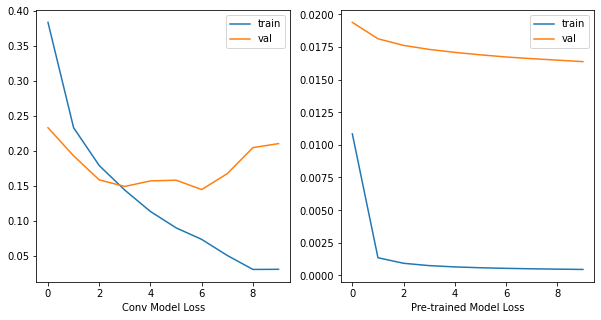

In [63]:
plot_losses([conv_log, ft_log])

What do you notice about the performance of the Conv Model over time? What about the pre-trained model? Is there a difference in val/train loss over time? Why could this be?

#### Observation:
Insert observation here

### A Practical Use-case of Pre-trained Models

You may have noticed from the last section, that our Conv model started to overfit slightly, while our Pre-trained model did not. This is actually an artifact of the "generalization" ability of pre-trained models. Let us go through a practical use-case of when we can make use of this.

Suppose that you are a scientist at a company that is tasked with building an image based classification system. And, you are working with the company's expensive, high quality, multi-class, and unsuprisingly proprietary dataset. This is great; however, the data is so expensive that you do not have very many samples to work with. In fact, you only have 200 of these high-quality data points to train on. 

Now you have a dilemna, should you build a custom model to train with this data, or should you fine-tune a pre-trained model? Let us try both.

First, we need to simulate working with a low-sample and multi-class dataset. Let us continue using CIFAR-10; however, we now need to make use of all 10 classes, but limit the number of samples per class.

In [64]:
np.random.seed(42) # to ensure re-producibility

Fill in the code to select ```sample_size``` number of examples for each of the 10 CIFAR-10 classes. Hint: use np.random.choice and make use of boolean-indexing

In [65]:
class ExpensiveDataset(datasets.CIFAR10):
    def __init__(self, *args, sample_size=20, **kwargs):
        super(ExpensiveDataset, self).__init__(*args, **kwargs)

        ### START CODE HERE
        targets = np.array(self.targets)
        
        for i in range(10):
            mask = targets == i
            
            sampleData = self.data[mask]
            sampleLabels = targets[mask]
            
            sampleIdxs = np.random.choice(sampleData.shape[0], sample_size)
            
            sampleData = sampleData[sampleIdxs]
            sampleLabels = sampleLabels[sampleIdxs].reshape(-1, 1)
            
            if i == 0:
                data = sampleData
                labels = sampleLabels
            else:
                data = np.concatenate((data, sampleData), axis=0)
                labels = np.concatenate((labels, sampleLabels), axis=0)

        self.data = data
        self.targets = labels.reshape(1,-1).tolist()[0]
        ### END CODE HERE

Similar to the previous section, let us initialize our dataset

In [66]:
tr_dataset = ExpensiveDataset('data', sample_size=20, train=True, download=True, transform=preprocess)
val_dataset = ExpensiveDataset('data', sample_size=10, train=False, download=True, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


How many tr/val examples do we have now?

In [67]:
### INSERT CODE HERE
tr_dataset.__len__(), val_dataset.__len__()
### END CODE HERE

(200, 100)

#### Observation:
Insert observation here

Now, create the dataloader to handle our new dataset. Hint: refer to above section for an example

In [68]:
batch_size = 4

### INSERT CODE HERE
train_data_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
### END CODE HERE

dataloaders = {'train' : train_data_loader,
              'val' : val_data_loader}

Make sure that the dimensions of your data loader inputs and labels are the same shape from before. Output a couple of examples.

In [69]:
### INSERT CODE HERE
for inputs, labels in train_data_loader:
    print(inputs.shape, labels.shape)
    break
### END CODE HERE

torch.Size([4, 3, 32, 32]) torch.Size([4])


Now instantiate a new pre-trained resnet model following the example from the top of the notebook. What are the changes that you have to make though? Hint: number of classes

In [70]:
### INSERT CODE HERE
model_ft = resnet18(pretrained=True).eval()
for params in model_ft.parameters():
    params.requires_grad = False
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
### END CODE HERE

Run the following blocks to train the pre-trained model on the new dataset, what do you notice about how long it takes?

In [72]:
num_epochs = 30
lr = 0.01
optimizer = optim.SGD(model_ft.parameters(), lr)
criterion = nn.CrossEntropyLoss()

In [73]:
model_ft, ft_loss = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs)

#### Observation:
Insert observation here

Now, instaniate a new ConvNet using the ```ConvNet``` class, similar to the previous section. Hint: what needs to change now that we are in a multi-class setting?

In [74]:
### INSERT CODE HERE
conv_model = ConvNet(10, 32, 32, 3)
### END CODE HERE

Run the following blocks to train your conv model. What do you notice about how long it takes?

In [75]:
num_epochs = 30
lr = 0.01
optimizer = optim.SGD(conv_model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

In [76]:
conv_model, conv_loss = train_model(conv_model, dataloaders, criterion, optimizer, num_epochs)

#### Observation:
Insert observation here

Now, run the following cell to plot the losses on this dataset. What do you notice? How is this different from the previous run? What model should you end up picking to work with in this "expensive" data situation? Please be detailed here. 

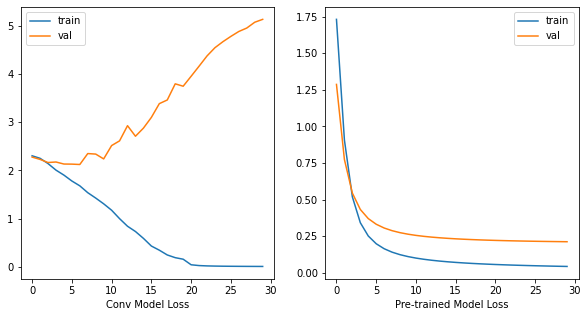

In [77]:
plot_losses([conv_loss, ft_loss])

#### Observation:
Insert observation here